# Information Retrieval - For RShiny Dashboard  
This notebook retrieves abstracts relevant to AI and then uses topic modeling to analyze the chosen abstracts.  Three info retrieval techniques are used: Literal Term Matching, TF-IDF, and Latent Semantic Indexing.  These are linear algebra techniques.  
We use the Scikit-Learn library.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time
import seaborn as sns

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

from gensim.models.phrases import Phrases, Phraser

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [2]:
# pull in entire dataframe

df = pd.read_pickle("~/dspg20RnD/data/final/final_dataset_7-20.pkl")

df.reset_index(inplace = True)
#df.rename(columns={'index':'original index'}, inplace=True)

In [3]:
df.head()

,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,...,working_abstract,Start_Char,nchar,LAST_CHAR,lemma_abstract,clean_lemmas,stopwds_removed,n_grams_added,final_tokens,final_frqwds_removed
0,0,17608,152242,The multiprotein complex y-secretase proteolyt...,2008,Active Sites; Affect; Alzheimer's Disease; Amy...,STRUCTURE OF SIGNAL PEPTIDE PEPTIDASE,HHS,NIH,NaN,...,The multiprotein complex y-secretase proteolyt...,T,1402,g,"[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y_secretase, proteolyt...","[multiprotein, y_secretase, proteolytically_cl..."
1,1,111864,190316,DESCRIPTION (provided by applicant): The Kis...,2008,Affect; Animal Model; Axon; Behavior; Behavior...,ROLE OF KISS1 NEURONS IN THE SEASONAL AND CIRC...,HHS,NIH,NaN,...,The Kissl gene encodes peptides called kisspep...,T,2553,y,"[Kissl, gene, encode, peptide, call, kisspepti...","[kissl, gene, encode, peptide, call, kisspepti...","[kissl, gene, encode, peptide, kisspeptin, bin...","[kissl, gene, encode, peptide, kisspeptin, bin...","[kissl, gene, encode, peptide, kisspeptin, bin...","[kissl, gene, encode, peptide, kisspeptin, bin..."
2,2,22052,154213,DESCRIPTION (provided by applicant): The objec...,2008,Agreement; Antibodies; base; Binding; Biochemi...,CARBONIC ANHYDRASE AS A MODEL TO UNDERSTAND DI...,HHS,NIH,NaN,...,The objective of this research is to understan...,T,1414,e,"[objective, research, be, understand, biophysi...","[objective, research, be, understand, biophysi...","[objective, research, understand, biophysical,...","[objective, research, understand, biophysical,...","[objective, research, understand, biophysical,...","[biophysical, basis, thermodynamics_kinetic, m..."
3,3,35004,159362,Obesity is the cause of many adverse pregnancy...,2008,African; Analysis of Variance; Asians; Birth; ...,OBESITY ON VAGAL TONE AND HBA1C DURING PREGNANCY,HHS,NIH,NaN,...,Obesity is the cause of many adverse pregnancy...,O,1545,d,"[obesity, cause, many, adverse, pregnancyoutco...","[obesity, cause, many, adverse, pregnancyoutco...","[obesity, cause, adverse, pregnancyoutcome, re...","[obesity, cause, adverse_pregnancyoutcome, res...","[obesity, cause, adverse_pregnancyoutcome, res...","[obesity, adverse_pregnancyoutcome, great, hea..."
4,4,371628,594482,Local potato advisory groups have expressed in...,2010,cost; Health; interest; Manure; Parasitic nema...,PLANT-PARASITIC NEMATODE MANAGEMENT AS A COMPO...,USDA,NIFA,NaN,...,Local potato advisory groups have expressed in...,L,271,s,"[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, express, interest, m..."


In [4]:
# input needed for doc-term matrix creation in Scikit-Learn is one string per document (not a list of strings).  
# Original data 'ABSTRACT' is already in this form, but not the tokens in "final_frqwds_removed"

tokens = df["final_frqwds_removed"]

docs = [] # docs will contain the processed tokens in string form (1 string per abstract)

for abstract in tokens:
    docs.append(" ".join(abstract))
    
docs = pd.Series(docs)

In [4]:
# to save time/storage -- only read in list of final tokens, ie. df["final_frqwds_removed"] - DO NOT USE
# creates a problem when indexing since this produces a list for tokens rather than a series
'''
f = open('../topic_model_tuning/coherence_vars20.sav', 'rb')

[corpus, id2word, tokens] = pickle.load(f)
f.close()

# corpus - word frequency in docs
# id2word - dictionary
# tokens - df["final_frqwds_removed"]
'''

## Functions needed for all info retrieval approaches

In [5]:
# Create query vector 

def create_query(words, terms):
    
    # words: search query words
    # terms: terms in corpus
    
    q = np.zeros(len(terms))  # number of terms

    idx = []
    for word in query_words:
        idx.append(terms.index(word))

    q[idx] = 1
    
    return q

In [6]:
def return_top_abstracts(docs, scores, top_n):
    
    '''
    docs: Series that contains abstract
    scores: scores of abstracts
    top_n: return the top_n abstracts given by idx, if top_n = -1 return all abstracts
    '''
    # sort scores in descending order
    scores_sorted_idx = np.argsort(scores)[::-1]
    
    if top_n == -1:
        n = sum(scores > 0)
        ix = scores_sorted_idx[:n]
    else:
        ix = scores_sorted_idx[:top_n]
    
    print(ix[0:10])
    
    return ix, docs[ix]
    

In [7]:
def create_result_df(abstracts, scores):
    
    df = pd.DataFrame()
    df["abstracts"] = abstracts
    df["scores"] = scores
    
    return df

## Literal Term Matching - Frequency Count Document-Term Matrix

This will return all abstracts in the corpus with exact word matches to the query.  

Results will be return in sorted order of how high the query scores with each abstract. A high score means more occurences of the query words in the abstract.

In [8]:
# Note - we are now using the spaCy stopwords list instead of nltk.  It is more comprehensive.
# ONLY USE THIS FUNCTION if using raw text to search

'''
def create_stopwords():
      
    """ creates list of stopwords. stop words include the general English list and any additional we see sneaking 
    through.  """
    
    spacy_stop_words = STOP_WORDS

    # more stop words that do not add meaning to topics
    additional_stopwords = {'addition', 'specifically', 'similar','including', 'particular', 
                            'furthermore','include', 'includes','overall', 'finally', 'specific', 
                            'additional'} 
           
    sw = spacy_stop_words.union(additional_stopwords)
    
    return sw
    
'''

'\ndef create_stopwords():\n      \n    """ creates list of stopwords. stop words include the general English list and any additional we see sneaking \n    through.  """\n    \n    spacy_stop_words = STOP_WORDS\n\n    # more stop words that do not add meaning to topics\n    additional_stopwords = {\'addition\', \'specifically\', \'similar\',\'including\', \'particular\', \n                            \'furthermore\',\'include\', \'includes\',\'overall\', \'finally\', \'specific\', \n                            \'additional\'} \n           \n    sw = spacy_stop_words.union(additional_stopwords)\n    \n    return sw\n    \n'

In [9]:
# Create document-term matrix based on count frequencies

#stop_words = create_stopwords()

vectorizer = CountVectorizer(lowercase=True, min_df=1)
doc_term_matrix = vectorizer.fit_transform(docs)

In [10]:
doc_term_matrix.shape

(690814, 1277822)

In [11]:
terms = vectorizer.get_feature_names()

### Create Query Words - list the search terms

A query is just a list of words to search for in the corpus.  We will use the same query for all three info retrieval techniques.

In [12]:
'artificial_intelligence' in terms

True

In [53]:
# ONLY USE FOR RAW TEXT STRING MATCHING

# tokens with - or strange symbol between words

'''
count = 0
idx = []

for ix, abstract in enumerate(df['ABSTRACT']):
    if 'artificial intelligence' in abstract.lower(): 
        count = count + 1
        idx.append(ix)
    elif 'artificialintelligence' in abstract.lower(): 
        count = count + 1
        idx.append(ix)
    elif 'artificially intelligent' in abstract.lower(): 
        count = count + 1
        idx.append(ix)
    #else: 
        # do nothing

print(count)

'''

796


In [13]:
# CHANGE QUERY WORDS HERE

query_words = ['artificial_intelligence', 'artificial_intelligence_ai', 
               'artificial_intelligence_machine_learning', 'artificialintelligence', 'artificially_intelligent',
               'artificial_intelligence_aaai', 'artificial_intelligence_ijcai', 'artificialintelligence_ai',
               'artificialintelligent'
              ] 

#'ai', 'artificial', 'intelligence' 
              
q = create_query(query_words, terms)

In [14]:
# calculate the score for each document against the query. Docs with more occurences of the query words 
# will score higher

f_scores = doc_term_matrix.dot(q)

In [15]:
sum(f_scores >0)  # how many abstracts include at least one of the query words

# some are being left off from raw counts

971

In [16]:
# sort scores in descending order

f_scores_sorted = np.sort(f_scores)[::-1]
f_scores_sorted[:10]

array([6., 5., 5., 4., 4., 4., 4., 4., 4., 3.])

In [17]:
f_idx, f_top_abstracts = return_top_abstracts(docs, f_scores, -1)  # CHANGE NUMBER OF TOP DOCS RETURNED

[493912  83585  10300  19512 293012 689629 637044 689591 429296 292485]


In [18]:
f_top_abstracts

493912    unique interdisciplinary team computer scienti...
83585     eager award education collaboration kindle_mat...
10300     graduate student attend workshop organize conj...
19512     aaai artificial_intelligence interactive digit...
293012    grant participation undergraduate student hold...
                                ...                        
363997    investigation topic temporal relation extracti...
32191     broader commercial small_business_innovation s...
357956    undergraduate reu site advance student technol...
145096    yale spore skin cancer skin cancer basal cell ...
122566    alignment rfa da 19_008 seek great_lakes node ...
Length: 971, dtype: object

In [19]:
f_top_abstracts.iloc[0]

'unique interdisciplinary team computer scientist scientist ornithologist manager programmer network machine_learning human observational capacity explore synergy mechanical computation human computation human computer learning network broad scale citizen science network wide applicability variety domain network active learning feedback_loop machine human dramatically continually effectiveness network human computer learning network leverage contribution broad recruitment human observer artificial_intelligence algorithm total computational power far exceed sum individual highly successful ebird citizen science testbed human computer learning network bird engage global network volunteer submit million bird observation annually central database fundamental challenge citizen science error identification classification object quantify difference individual observer spatial bias prevalent citizen science challenge build advance artificial_intelligence opportunity generation account enormous

In [20]:
df['ABSTRACT'][493912]

"A unique interdisciplinary team of computer scientists, information scientists, ornithologists, project managers, and programmers will develop a novel network between machine learning methods and human observational capacity to explore the synergies between mechanical computation and human computation. This is called a Human/Computer Learning Network, and while the focus is to improve data quality in broad-scale citizen-science projects, the network has the potential for wide applicability in a variety of complex problem domains. The core of this network is an active learning feedback loop between machines and humans that dramatically improves the quality of both, and thereby continually improves the effectiveness of the network as a whole. The Human/Computer Learning Network will leverage the contributions of broad recruitment of human observers and process their contributed data with artificial intelligence algorithms leading to a total computational power far exceeding the sum of t

## TF-IDF Document-Term Matrix

This approach is similar to Literal Term Matching using frequency counts in the document-term matrix.  However, instead of using frequency counts, the entries of the document-term matrix are weighted using TF-IDF.

In [21]:
# Find doc-term matrix using TF-IDF weighting

tf_idf_vectorizer = TfidfVectorizer(lowercase=True, min_df=1)
tf_idf = tf_idf_vectorizer.fit_transform(docs)

In [22]:
tf_idf_terms = tf_idf_vectorizer.get_feature_names()  # these terms are the same as the terms created from the 
                                                      # frequency count document-term matrix, so we do not need to
                                                      # recreate the query vector.

In [23]:
tf_idf_terms == terms

True

In [24]:
# calculate the score for each document against the query. Docs with more occurences of the query words 
# will score higher

tf_idf_scores = tf_idf.dot(q)

In [25]:
sum(tf_idf_scores >0)   # how many abstracts include at least one of the query words

971

In [26]:
# sort scores in descending order

tf_idf_scores_sorted = np.sort(tf_idf_scores)[::-1]
tf_idf_scores_sorted[:10]

array([0.67110913, 0.50600405, 0.44719966, 0.42104089, 0.40140886,
       0.39908403, 0.37190372, 0.37129172, 0.37005479, 0.3416502 ])

In [27]:
tfidf_idx, tfidf_top_abstracts = return_top_abstracts(docs, tf_idf_scores, -1)  # CHANGE NUMBER OF TOP DOCS RETURNED

[235101 293012  10300 209895 493912 366791 581817 232572 108705 531638]


In [28]:
tfidf_top_abstracts

235101    phd student artificial_intelligence opportunit...
293012    grant participation undergraduate student hold...
10300     graduate student attend workshop organize conj...
209895    imperative environmental societal sustainabili...
493912    unique interdisciplinary team computer scienti...
                                ...                        
168231    animal human means better human barrier progre...
688857    generate humanity past exceed create human his...
114280    elderly patient dementia present massive care ...
638620    scene ie recognize object human action event i...
237025    background people multiple_sclerosis_ms chroni...
Length: 971, dtype: object

In [29]:
tfidf_top_abstracts.iloc[0]

'phd student artificial_intelligence opportunity share interact senior learn sub ai mentor publication career opportunity accomplish partially travel cost phd student attend international joint conference artificial_intelligence_ijcai premier international conference artificial_intelligence conference 2017 hold melbourne_australia attract international crowd academics industry worker entrepreneur funding agency leader'

In [30]:
df['ABSTRACT'][235101]

'This proposal will support US-based Ph.D. students working in artificial intelligence the opportunity to share their knowledge and interact with each other and more senior researchers, to learn about different sub-fields within AI, and to be mentored in research, publication, and career opportunities. This goal will be accomplished by partially supporting the travel costs for US-based Ph.D. students to attend the International Joint Conference on Artificial Intelligence (IJCAI), which is one of the premier international conferences on research in artificial intelligence. The conference, which in 2017 will be held in Melbourne, Australia attracts an international crowd that includes academics, industry workers, entrepreneurs, and funding agency leaders.'

## Latent Semantic Indexing (LSI) Approach

LSI Uses the TF-IDF matrix.  LSI is a tecnique that utilizes a truncated Singular Value Decomposition of the document-term matrix.  Basically, LSI still returns relevant documents to the query; however some of the documents returned may not include the exact search terms!  LSI is finding the latent or hidden relationships in the terms.  

In [31]:
# Find the Truncated SVD of the TF-IDF matrix

lsa = TruncatedSVD(n_components=500, random_state=1)  # CHANGE THE NUMBER OF COMPONENTS - NOTE: MORE COMPONENTS 
                                                      # GIVES YOU A MORE ACCURATE APPROXIMATION OF THE DOC-TERM 
                                                      # MATRIX, BUT IS ALSO MORE EXPENSIVE AND MAY NOT LEAD TO THE 
                                                      # BEST INFO RETRIEVAL RESULTS.
USigma = lsa.fit_transform(tf_idf)
Vtrans = lsa.components_

In [32]:
# transform query to be in same space as documents

q = q.reshape(1,-1)
qhat = lsa.transform(q)

In [33]:
print(qhat.shape)
print(USigma.shape)
print(Vtrans.shape)

(1, 500)
(690814, 500)
(500, 1277822)


In [35]:
lsa_scores = pairwise_distances(qhat, USigma, metric='cosine', n_jobs=7)  # CHANGE N_JOBS TO BE NUMBER OF CORES - 1

In [36]:
lsa_scores.shape

(1, 690814)

In [37]:
lsa_scores

array([[0.99236369, 0.96254083, 0.99793398, ..., 0.9605319 , 1.00196225,
        1.04424589]])

In [38]:
lsa_scores[0]

array([0.99236369, 0.96254083, 0.99793398, ..., 0.9605319 , 1.00196225,
       1.04424589])

In [39]:
sum(lsa_scores[0] > 0)  # how many abstracts scored above 0

690814

In [40]:
# sort scores in descending order

lsa_scores_sorted = np.sort(lsa_scores[0])[::-1]
lsa_scores_sorted[:10]

array([1.14614006, 1.1378564 , 1.12743337, 1.12316128, 1.12287109,
       1.12060152, 1.11858765, 1.11773294, 1.11709405, 1.11691335])

In [41]:
lsa_idx, lsa_top_abstracts = return_top_abstracts(docs, lsa_scores[0], 50)  # CHANGE NUMBER OF TOP DOCS RETURNED

[671417 395223 423786 590413 320655 674822 352765  51594 558851 463708]


In [42]:
lsa_top_abstracts

671417    investigation magnetic_reconnection geometry s...
395223    concerned nonlinear_elliptic_parabolic_equatio...
423786    award pi postdoctoral supervision dr meers opp...
590413    offer annual week short course functional magn...
320655    student nationwide place developmental math en...
674822    station great_plains participant access experi...
352765    scattering wafe acoustic radio optical inescap...
51594     lateral stirring fundamental advection diapycn...
558851    partially average_navier_stokes pan turbulence...
463708    hard x_ray emission black_hole observate cyg i...
66959     nanotechnology undergraduate education nue_eng...
6987      mathematical sciences reformulate standard sem...
127137    superfund basic translation seek deliver membe...
521029    background hivcontinuestobeapressingpublicheal...
292613    responsibility managerial communicationsupport...
296382    responsibility managerial communicationsupport...
301280    responsibility managerial comm

In [53]:
lsa_top_abstracts.iloc[41]

'aspect gravity gravitational_collapse gravitational radiation object gravity strong trap light object black_hole black_hole object smaller smaller influence gravity point infinite density infinite gravitational singularity property singularity gravitational_collapse force feel observer singularity electric radio transmitter radio wafe mass gravity_wafe radio receiver react presence radio wafe ongoing detect gravitational_wafe interesting aspect gravitational radiation gravitational_wave memory wave pass permanent gravitational_wave_detector property gravitational_wave memory conjecture singularity black_hole consist spacelike singularity black_hole null singularity place black_hole inner horizon singularity numerical previously simulation spacelike singularity simulation reveal presence small spatial scale spike resolve simulation revisit simulation adaptive_mesh_refinement serve resolve spike simulation analytic approximation spike expect equation singularity null singularity double 

In [52]:
df['ABSTRACT'][344482]

"This project will study two aspects of gravity: (1) gravitational collapse and (2) gravitational radiation.  (1) When an object's gravity becomes strong enough to trap light, the object becomes a black hole.  Inside the black hole the object continues to become smaller and smaller under the influence of its own gravity until it becomes a point with infinite density and infinite gravitational field called a singularity.  I will work out the properties of the singularities formed in gravitational collapse, and in particular the forces felt by any observer who approaches the singularity.  (2) Just as the electric currents in a radio transmitter make radio waves, so moving masses make gravity waves.  And just as radio receivers react to the presence of radio waves, so there is an ongoing effort to detect gravitational waves.  One interesting aspect of gravitational radiation is something called gravitational wave memory: even after the wave has passed, there is a permanent change in the g

In [ ]:
# I don't think LSI is giving us AI results - I spot checked 5-10 of these.  

## Create pandemics corpus

We use the results of our three information retrieval techniques to create a new, smaller corpus that only contains abstracts relevant to the query. 

In [68]:
docs_ix = np.concatenate([f_idx, tfidf_idx]) #lsa_idx])

In [69]:
docs_idx = np.unique(docs_ix)

In [70]:
docs_idx.shape

(971,)

In [72]:
#lim_docs = [tokens[i] for i in docs_idx]

**create case-study corpuses**

In [71]:
ai_corpus = df.loc[docs_idx, :]

In [72]:
ai_corpus.shape

(971, 40)

In [2]:
#ai_corpus.to_pickle("./ai_corpus.pkl")
ai_corpus = pd.read_pickle("ai_corpus.pkl")

In [3]:
lim_docs = ai_corpus["final_frqwds_removed"]

### add more bigrams relevant to the AI corpus

In [80]:
def add_n_grams(docs):

    #Calculate bi and tri grams on tokenized, lemmatized, and stop words removed abstracts -- gensim

    # Build the bigram and trigram models
    bi_phrases = Phrases(docs, min_count=5, threshold=50.0) # higher threshold --> fewer phrases.
    bigram = Phraser(bi_phrases)  # should provide a speed-up
    bi_docs = bigram[docs]
    
    tri_phrases = Phrases(bi_docs, threshold=100)  
    trigram = Phraser(tri_phrases)
    tri_docs = trigram[bi_docs]

    return tri_docs

In [81]:
# add in bigrams and trigrams 

ai_corpus = ai_corpus.assign(AI_n_grams = add_n_grams(ai_corpus["final_frqwds_removed"]))

In [82]:
ai_corpus["AI_n_grams"]

206       [modern, digital, pathology, department, treme...
207       [modern, digital, pathology, department, treme...
2940      [fund, participation, approximately, graduate,...
2988      [literature, causal, statistical_inference, ca...
3035      [literature, causal, statistical_inference, ca...
                                ...                        
689626    [bring, discipline, partner, range, sense, mon...
689629    [future, human, technology, frontier_fw_htf, b...
689759    [artificial_intelligence, fuel, recent, advanc...
689813    [future, human, technology, frontier_fw_htf, b...
689838    [undergraduate, stem, education, hispanic_serv...
Name: AI_n_grams, Length: 971, dtype: object

In [83]:
ai_corpus["final_frqwds_removed"]

206       [modern, digital, pathology, department, treme...
207       [modern, digital, pathology, department, treme...
2940      [fund, participation, approximately, graduate,...
2988      [literature, causal, statistical, inference, c...
3035      [literature, causal, statistical, inference, c...
                                ...                        
689626    [bring, discipline, partner, range, sense, mon...
689629    [future, human, technology, frontier_fw_htf, b...
689759    [artificial_intelligence, fuel, recent, advanc...
689813    [future, human, technology, frontier_fw_htf, b...
689838    [undergraduate, stem, education, hispanic_serv...
Name: final_frqwds_removed, Length: 971, dtype: object

In [84]:
lim_docs = ai_corpus["AI_n_grams"]

In [4]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []

for token_list in lim_docs:
    text.append(" ".join(token_list))

In [5]:
len(lim_docs)

971

## Topic Modeling with relevant AI abstracts

In [6]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [7]:
# Create a TF-IDF document-term matrix for the pandemics corpus 

# TRY DIFFERENT PARAMETERS IN THE TF-IDF DOC-TERM MATRIX SET-UP
nmf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=True) #, max_features=int(len(lim_docs)/2))

# by default TfidfVectorizer has l2 normalization for rows: 
# from Scikit Learn documentation: Each output row will have unit norm, either: * ‘l2’: Sum of squares of vector 
# elements is 1. The cosine similarity between two vectors is their dot product when l2 norm has been applied.

nmf_tf_idf = nmf_vectorizer.fit_transform(text)

In [8]:
nmf_tf_idf.shape

(971, 4541)

In [9]:
AI_terms = nmf_vectorizer.get_feature_names()

In [10]:
AI_terms[2830:2850]

['offering',
 'office',
 'offline',
 'ofresearch',
 'oise',
 'old',
 'older',
 'omic',
 'omnidirectional',
 'oncologist',
 'oncology',
 'ongoing',
 'online',
 'onset',
 'ontological',
 'ontology',
 'open',
 'opening',
 'openly',
 'operate']

In [11]:
# topic modeling with NMF

nmf_model = NMF(n_components=50, random_state=1)  # TRY DIFFERENT NUMBERS OF TOPICS
W = nmf_model.fit_transform(nmf_tf_idf)
H = nmf_model.components_

In [12]:
print_topics(nmf_model, nmf_vectorizer, 10)


Topic 0:
('student', 10.25011784366269)
('feedback', 1.9933188380869409)
('course', 1.8717201682370164)
('scientific', 1.8704158815154461)
('skill', 1.810491734588173)
('engineering', 1.6841615160916088)
('reasoning', 1.6042815502871095)
('undergraduate', 1.4650026768968247)
('stem', 1.2750578138442712)
('sketch', 1.2420352236141001)

Topic 1:
('doctoral', 1.109069417873002)
('conference', 0.8931524776568097)
('consortium', 0.783160368701892)
('student', 0.5856621383530445)
('international', 0.40669839036502764)
('participation', 0.3197381081014328)
('travel', 0.29688276069987435)
('career', 0.2540913151984528)
('mentor', 0.24947554119001408)
('hold', 0.23924937857232156)

Topic 2:
('patient', 1.8727233695587682)
('care', 0.8051149521490093)
('health', 0.4841761560316454)
('nurse', 0.3394828218075948)
('provider', 0.3367654519400201)
('clinical', 0.3168866730486992)
('healthcare', 0.3036572595381263)
('medical', 0.2667140696921884)
('medication', 0.2478451784772965)
('falls', 0.239612

### package topics into CSV

In [16]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

In [17]:
topic_words = str_topics(H, nmf_vectorizer, 10)

In [18]:
topic_words[:10]

['student, feedback, course, scientific, skill, engineering, reasoning, undergraduate, stem, sketch',
 'doctoral, conference, consortium, student, international, participation, travel, career, mentor, hold',
 'patient, care, health, nurse, provider, clinical, healthcare, medical, medication, falls',
 'deep, network, neural, learning, architecture, cnn, representation, processing, train, layer',
 'participant, hri, conference, panel, workshop, poster_session, interaction, human, senior, presentation',
 'melanoma, spore, skin, cancer, yale, epigenetic, modifier, specimen, basal, serological',
 'technology, manufacturing, worker, job, future, stem, industry, automation, productivity, workforce',
 'brain, imaging, equipment, caltech, neuroscience, mri, tissue, resolution, tumor, upgrade',
 'algorithm, optimization, approximation, stochastic, theory, efficient, algorithmic, machine_learning, theoretical, computer',
 'language, natural, word, umr, linguistic, representation, meaning, process

In [19]:
topic_results = pd.DataFrame()
topic_results["Topic Words"] = topic_words 

In [20]:
topic_results

,Topic Words
0,"student, feedback, course, scientific, skill, ..."
1,"doctoral, conference, consortium, student, int..."
2,"patient, care, health, nurse, provider, clinic..."
3,"deep, network, neural, learning, architecture,..."
4,"participant, hri, conference, panel, workshop,..."
5,"melanoma, spore, skin, cancer, yale, epigeneti..."
6,"technology, manufacturing, worker, job, future..."
7,"brain, imaging, equipment, caltech, neuroscien..."
8,"algorithm, optimization, approximation, stocha..."
9,"language, natural, word, umr, linguistic, repr..."


In [21]:
topic_results.to_csv("./AI_50_topics.csv", index=False)

### properties of AI dataset

In [11]:
ai_corpus.head()

,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,...,working_abstract,Start_Char,nchar,LAST_CHAR,lemma_abstract,clean_lemmas,stopwds_removed,n_grams_added,final_tokens,final_frqwds_removed
206,206,1094356,1130812,PROJECT SUMMARY / ABSTRACTModern digital patho...,2019,actionable mutation; anticancer research; Arch...,GENOTYPE AND HISTOLOGICAL PHENOTYPE RELATIONSH...,HHS,NIH,NCI,...,Modern digital pathology departments produce a...,M,3058,e,"[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, treme..."
207,207,938623,931185,PROJECT SUMMARY / ABSTRACTModern digital patho...,2017,actionable mutation; anticancer research; Arch...,GENOTYPE AND HISTOLOGICAL PHENOTYPE RELATIONSH...,HHS,NIH,NCI,...,Modern digital pathology departments produce a...,M,3059,e,"[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, treme..."
2940,2940,197954,119775,This is funding to support participation by ap...,2009,Academia; Artificial Intelligence; Arts; base;...,SUPPORTING STUDENTS ATTENDING IUI 2009 CONFERENCE,NSF,NSF,NaN,...,This is funding to support participation by ap...,T,3170,e,"[fund, support, participation, approximately, ...","[fund, support, participation, approximately, ...","[fund, support, participation, approximately, ...","[fund, support, participation, approximately, ...","[fund, support, participation, approximately, ...","[fund, participation, approximately, graduate,..."
2988,2988,197569,119389,Within the literature on causal statistical in...,2009,Affect; Agriculture; Applied Research; Area; A...,COLLAB. PROPOSAL: PARTIAL AND POINT IDENTIFICA...,NSF,NSF,NaN,...,Within the literature on causal statistical in...,W,4672,t,"[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, c..."
3035,3035,197568,119388,Within the literature on causal statistical in...,2009,Affect; Agriculture; Applied Research; Area; A...,PARTIAL AND POINT IDENTIFICATION OF CAUSAL NET...,NSF,NSF,NaN,...,Within the literature on causal statistical in...,W,4714,t,"[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, c..."


In [92]:
# project terms - worth looking into??

ai_corpus['PROJECT_TERMS'].iloc[500] # does not have artificial intelligence as key term

'Address; Antibodies; Antiviral Agents; Applications Grants; Applied Research; Area; Arts; base; Basic Science; Biochemical; Biology; Cancer Center Support Grant; cancer immunotherapy; cancer therapy; Cellular biology; Chemicals; Chemistry; Clinic; Clinical; clinical candidate; clinical care; clinical development; Clinical Investigator; Clinical Research; Clinical Trials; Clinical Trials Network; Code; Collaborations; Colorectal Cancer; Conduct Clinical Trials; Cytotoxic Chemotherapy; design; Development; Developmental Therapeutics Program; Direct Costs; Disease; DNA Repair; drug candidate; drug discovery; early phase trial; Engineering; Evaluation; Faculty; Funding; Future; Genome; Genomics; Goals; Grant; Hospitals; Immune; Immunotherapy; innovation; insight; Institute of Medicine (U.S.); Institutes; invention; Investigational Therapies; Investments; kinase inhibitor; Laboratories; Lead; Leadership; Link; Lung; Malignant neoplasm of lung; Malignant Neoplasms; Medical; medical schools;

In [93]:
ai_corpus['ABSTRACT'].iloc[500]

"Project Summary/Abstract The objective of Stanford's proposed Health Services Research Training Program (HSRTP) is to developindependent, well-trained, diverse researchers who conduct rigorous and innovative health services research(HSR) on important challenges facing the U.S. health care system. Our program design is motivated by ourview that excellent health services researchers need a strong grasp of core disciplinary skills, the ability tofunction in multidisciplinary settings, and the ability to engage with both traditional and emerging researchcontexts. Accordingly, our program emphasizes strong disciplinary training in our core areas of healtheconomics, outcomes research, and decision science. We provide this training within the rich multidisciplinaryenvironment of our integrated campus. Our trainees will frequently be side-by-side with trainees and facultyfrom areas like clinical medicine, economics, engineering, ethics, informatics, and law. Mentored research experiences are 

NSF     725
HHS     223
ED        8
DOD       6
VA        5
USDA      3
EPA       1
Name: DEPARTMENT, dtype: int64


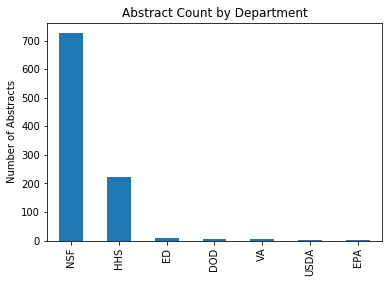

In [12]:
# plot number of abstracts by department

y = ai_corpus["DEPARTMENT"].value_counts()
y.plot(kind = 'bar')
plt.ylabel('Number of Abstracts')
plt.title('Abstract Count by Department');

print(y)

In [12]:
# plot number of abstracts by project start year

# extract year from project start date

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

ai_corpus['START_YEAR'] = ai_corpus['PROJECT_START_DATE'].apply(getYear)

1977      3
1987      2
1997      1
2002      1
2003      1
2004      2
2005      3
2006      8
2007      5
2008     38
2009     60
2010     56
2011     53
2012     61
2013     47
2014     44
2015     64
2016     84
2017    139
2018    227
2019     72
Name: START_YEAR, dtype: int64


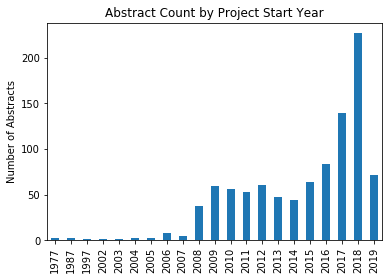

In [15]:
y = ai_corpus["START_YEAR"].value_counts().sort_index()
y.plot(kind = 'bar')
plt.ylabel('Number of Abstracts')
plt.title('Abstract Count by Project Start Year');

print(y)

In [28]:
# plot dollars by year

dollars_by_year = ai_corpus.groupby(by = ['START_YEAR']).sum()
dollars_by_year["FY_TOTAL_COST"] = dollars_by_year["FY_TOTAL_COST"]/1000000

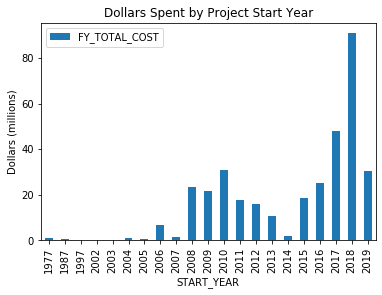

In [31]:
dollars_by_year.plot.bar(y = "FY_TOTAL_COST")
plt.ylabel('Dollars (millions)')
plt.title('Dollars Spent by Project Start Year');


In [14]:
# plot dollars by year & department

dollars_by_deptNyear = ai_corpus.groupby(by = ['START_YEAR','DEPARTMENT']).sum()
dollars_by_deptNyear["FY_TOTAL_COST"] = dollars_by_deptNyear["FY_TOTAL_COST"]/1000000

dollars_by_deptNyear

,,index,original index,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,nchar
START_YEAR,DEPARTMENT,,,,,,,
1977,HHS,1241229,1113451,1.141446,0.0,3,4,6668
1987,HHS,764375,231535,0.510160,0.0,2,2,4979
1997,HHS,646480,1107697,0.000000,59104.0,1,1,2869
2002,HHS,396611,36595,0.364134,0.0,1,1,1712
2003,HHS,457682,1051077,0.378026,0.0,1,1,3157
2004,HHS,546536,1082534,1.001188,0.0,2,2,4834
2005,HHS,1384876,888213,0.750220,0.0,3,3,11918
2006,HHS,3196253,1065385,6.728157,0.0,8,8,18870
2007,HHS,1212214,265585,1.190586,0.0,5,4,10059


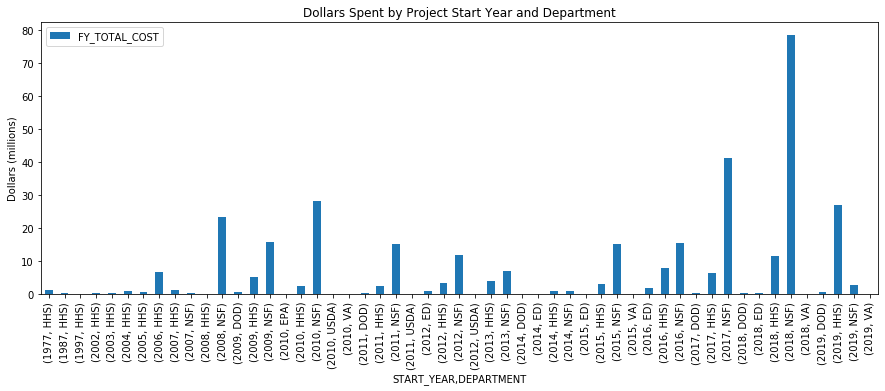

In [15]:
dollars_by_deptNyear.plot.bar(y = "FY_TOTAL_COST", figsize=(15,5))
plt.ylabel('Dollars (millions)')
plt.title('Dollars Spent by Project Start Year and Department');

In [16]:
dollars_by_deptNyear = dollars_by_deptNyear.reset_index()

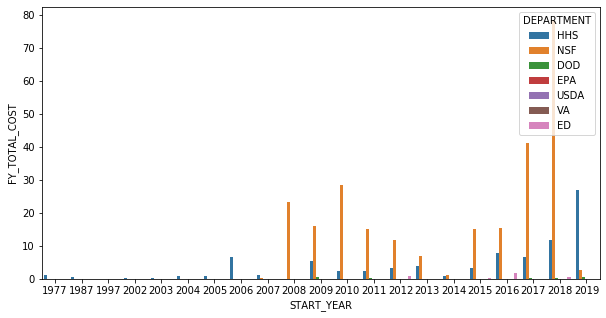

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(ax=ax, x="START_YEAR", y="FY_TOTAL_COST", hue="DEPARTMENT", data=dollars_by_deptNyear)

# Most important words in AI corpus

In [105]:
# calculate leverage score for each column

AI_svd = TruncatedSVD(n_components=10, random_state=1)  
USigma = AI_svd.fit_transform(nmf_tf_idf)
Vtrans = AI_svd.components_

In [106]:
Vtrans.shape

(10, 4811)

In [107]:
Vtrans_sq = Vtrans**2

In [108]:
Vtrans[0,0]

0.0020412172299528303

In [109]:
Vtrans_sq[0,0]

4.166567779856306e-06

In [110]:
Vtrans[0,0]*Vtrans[0,0]

4.166567779856306e-06

In [111]:
type(Vtrans_sq)

numpy.ndarray

In [112]:
# find column sums of V' (instead of row sums of V) and then divide by k = 10

lev_scores = np.sum(Vtrans_sq, axis = 0)/10

In [113]:
mat = np.array([[0, 1, 2], [0, 5, 3]])  # row format...shape of this is 2x3

In [114]:
np.sum(mat, axis=1)

array([3, 8])

In [115]:
# sort leverage scores in descending order and keep index of sorted elements

lev_idx = np.argsort(lev_scores)[::-1]

In [116]:
lev_idx = lev_idx.tolist()

In [117]:
lev_idx

[4193,
 3129,
 2389,
 2031,
 4700,
 542,
 4792,
 892,
 188,
 726,
 1825,
 2420,
 2067,
 2888,
 2418,
 4321,
 4334,
 3106,
 3790,
 175,
 1478,
 3864,
 760,
 857,
 869,
 4032,
 3852,
 161,
 4804,
 4371,
 1307,
 4457,
 2868,
 2459,
 1119,
 865,
 2071,
 600,
 4046,
 4316,
 2865,
 620,
 4356,
 1899,
 3712,
 1504,
 2518,
 2268,
 2629,
 1134,
 3794,
 4096,
 1471,
 331,
 1954,
 2884,
 1539,
 2996,
 1513,
 4378,
 727,
 4747,
 1179,
 603,
 732,
 1956,
 2232,
 3130,
 4785,
 2956,
 2256,
 287,
 2179,
 2516,
 4147,
 3022,
 121,
 4111,
 1014,
 1512,
 1861,
 1514,
 2669,
 3338,
 4006,
 2754,
 2630,
 602,
 601,
 615,
 2308,
 4405,
 3241,
 3157,
 4110,
 4477,
 2122,
 4630,
 3234,
 3148,
 1382,
 621,
 4140,
 1206,
 1700,
 4550,
 2557,
 3862,
 4109,
 1446,
 3171,
 1940,
 2154,
 661,
 4003,
 2828,
 4802,
 1392,
 1023,
 4368,
 553,
 3402,
 2343,
 1132,
 408,
 486,
 1345,
 3354,
 3014,
 3922,
 3108,
 2545,
 3890,
 1030,
 2275,
 2856,
 3866,
 1383,
 1881,
 1552,
 4068,
 1306,
 4323,
 688,
 2242,
 3355,
 2150

In [118]:
lev_scores[lev_idx]

array([3.97780314e-02, 2.76338069e-02, 2.13432446e-02, ...,
       5.84326696e-07, 5.81723482e-07, 3.97537898e-07])

In [119]:
top_words = [nmf_vectorizer.get_feature_names()[i] for i in lev_idx[:100]]

In [120]:
top_words

['student',
 'patient',
 'language',
 'human',
 'visual',
 'brain',
 'workshop',
 'conference',
 'algorithm',
 'clinical',
 'game',
 'learning',
 'image',
 'neuroscience',
 'learn',
 'teacher',
 'technology',
 'participant',
 'robot',
 'ai',
 'engineering',
 'science',
 'cognitive',
 'computational',
 'computing',
 'social',
 'scene',
 'agent',
 'yale_spore_skin_cancer',
 'theory',
 'doctoral_consortium',
 'trainee',
 'neural',
 'linguistic',
 'decision',
 'computer',
 'imaging',
 'cancer',
 'software',
 'task',
 'network',
 'care',
 'text',
 'graduate',
 'representation',
 'environment',
 'machine_learning',
 'interface',
 'melanoma',
 'deep_learning',
 'robotics',
 'speech',
 'energy',
 'assessment',
 'health',
 'neuron',
 'establishment_composite_database_skin',
 'onset_basal_cell_carcinoma',
 'epigenetic_modifier_immune_modulation',
 'therapy_melanoma_respectively_spore',
 'clinical_throughput_proteomic',
 'web_benefit_wider',
 'dermatology_pathology_epidemiology_public',
 'cancer_

In [13]:
# next step - look at documents containing topics like breast cancer (topic 17)

topic_docs = W[:, 21]

In [14]:
sum(topic_docs > 0) 

269

In [16]:
max_score = max(topic_docs)
max_score

0.42245060347796837

In [17]:
topic_docs[0:20]

array([0.00119196, 0.00129095, 0.        , 0.00067637, 0.00050862,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0139517 , 0.000811  , 0.        , 0.        ,
       0.        , 0.        , 0.01106404, 0.        , 0.03714427])

In [120]:
print(lim_docs.iloc[2])

['literature', 'causal', 'statistical', 'inference', 'causal', 'channel', 'interest', 'net', 'direct', 'causal', 'block', 'variable', 'represent', 'net', 'useful', 'learn', 'way', 'causally', 'policy', 'purpose', 'evaluation', 'evident', 'importance', 'latest', 'theoretical', 'definition', 'identification', 'estimation', 'place', 'economics', 'introduce', 'net', 'economics', 'employ', 'familiar', 'econometric', 'language', 'ii', 'literature', 'causal', 'partial', 'point', 'identification', 'nonparametric_parametric', 'assignment', 'heterogeneous', 'iii', 'relevant', 'simulation', 'guide', 'future', 'apply', 'employ', 'framework', 'neyman', '1923', 'rubin', '1974', 'related', 'concept', 'principal', 'stratification', 'frangakis_rubin_2002', 'introduce', 'economics', 'concept', 'net', 'average', 'nate', 'average', 'mate', 'decompose', 'total', 'average', 'eat', 'related', 'concept', 'previously', 'introduce', 'robins', 'greenland', '1992', 'pearl', '2001', 'second', 'nonparametric', 'par

In [18]:
idx = np.where(topic_docs == max_score)

In [19]:
idx

(array([ 26, 745]),)

In [25]:
idx = np.where(topic_docs > 0.3)
idx

(array([ 26,  39,  41, 318, 745, 759]),)

In [20]:
topic_docs[10:30]

array([0.        , 0.0139517 , 0.000811  , 0.        , 0.        ,
       0.        , 0.        , 0.01106404, 0.        , 0.03714427,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.4224506 , 0.01098602, 0.02576101, 0.        ])

In [23]:
print(lim_docs.iloc[745]) # breast cancer topic with AI component

['intervene', 'psychosis', 'onset', 'prevent', 'morbidity', 'recent', 'schizophrenia', 'identification', 'young', 'people', 'putative', 'prodromal', 'period', 'safe', 'modify', 'course', 'past_decade', 'columbia', 'clinical', 'chr', 'individual', 'range', 'cognitive', 'deficit', 'schizophrenia', 'evident', 'psychosis', 'onset', 'subtle', 'think', 'disorder', 'manifest', 'disturbance', 'language', 'production', 'feature', 'predate', 'psychosis', 'onset', 'chr', 'individual', 'indicator', 'schizophrenia', 'liability', 'subtle', 'think', 'disorder', 'schizophrenia', 'typically', 'clinical', 'rating', 'scale', 'occasionally', 'labor_intensive', 'manual', 'linguistic', 'instead', 'automated', 'machine_learning', 'speech', 'inform', 'artificial_intelligence', 'derive', 'semantic', 'meaning_word_phrase', 'draw', 'corpus', 'text', 'human', 'assign', 'mean', 'language', 'syntax', 'speech', 'tagging', 'yield', 'fine_grain', 'index', 'speech', 'semantic_syntax', 'accurately', 'capture', 'subtle',

In [29]:
ai_corpus["ABSTRACT"].iloc[759]

'Project Summary In an effort to intervene before psychosis onset and prevent morbidity, a major recent focus inschizophrenia research has been the identification of young people during a putative prodromal period, so asto develop safe and effective interventions to modify disease course. Over the past decade, studies atColumbia and elsewhere have evaluated clinical high-risk (CHR) individuals across a wide range of cognitiveprocesses to try to identify core deficits of schizophrenia evident before psychosis onset. Subthreshold thoughtdisorder and impaired emotion recognition have emerged as profound deficits that predate, rather than follow,psychosis onset and thus may be indicators of schizophrenia liability, consistent with studies in other riskcohorts, including genetic high risk. Further, subthreshold thought disorder and emotion recognition deficit aresignificantly correlated, suggesting shared neural substrates in temporoparietal regions. This study aims to identify the neural m

In [238]:
# TRY TOPIC MODELING WITH LDA

# create document-term matrix

lda_vectorizer = CountVectorizer(max_df=1.0, min_df=3, lowercase=True)
lda_dtm = lda_vectorizer.fit_transform(text)

In [239]:
# create model

num_topics = 30
lda_model = LatentDirichletAllocation(n_components=num_topics, doc_topic_prior = 1/num_topics, 
                                      topic_word_prior=0.1, n_jobs=39, random_state = 0)
doc_top_dist = lda_model.fit_transform(lda_dtm)
top_term_dist = lda_model.components_

In [240]:
print_topics(lda_model, lda_vectorizer, 10)


Topic 0:
('protein', 225.55502749264147)
('receptor', 183.95759402950594)
('cell', 172.4504639973329)
('bind', 108.84685928736633)
('structural', 83.23407993256878)
('virus', 81.06300054201091)
('viral', 75.5561411680632)
('interaction', 68.26001146683492)
('human', 67.85457954982031)
('host', 64.82284755171038)

Topic 1:
('subset', 81.29454728313978)
('cd4', 66.23840025065098)
('memory', 62.37910850799191)
('effector', 40.5848650803486)
('viral', 40.11634209137843)
('cell', 36.6079502522241)
('rna', 36.412992443476384)
('orf', 35.0999999999997)
('protection', 33.610323276130394)
('protein', 29.212279854306338)

Topic 2:
('cell', 202.03669046303705)
('death', 163.99491597475762)
('protein', 84.11074125989704)
('human', 76.15368948404043)
('receptor', 61.47717954877514)
('cycle', 58.31210018295787)
('autophagy', 45.205793172633825)
('cellular', 39.855071437383906)
('virus', 39.49494201595987)
('play', 34.583390658500534)

Topic 3:
('virus', 503.9476289736178)
('viral', 325.232153571429